In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-08-19 12:19:44.036449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


2025-08-19 12:19:47.069926: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-19 12:19:49.559027: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-19 12:19:49.559084: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-19 12:19:49.560101: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:926] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-19 12:19:49.560165: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

1 Physical GPUs, 1 Logical GPUs


In [42]:
# load images and labels 

from collections import Counter

imageFileNames = tf.data.Dataset.list_files('./images/*', shuffle=False)

allLabelDict = {}

labelDict = Counter()
cellShapeDict = Counter()
nucleusShapeDict = Counter()
cytoplasmVacuoleDict = Counter()

with open("./dev_data_2025.csv", "r") as f:
	csvItems = list(csv.DictReader(f))
	for imgLabel in csvItems:
		labelDict[imgLabel['label']] += 1
		cellShapeDict[imgLabel['cell_shape']] += 1
		nucleusShapeDict[imgLabel['nucleus_shape']] += 1
		cytoplasmVacuoleDict[imgLabel['cytoplasm_vacuole']] += 1

	labelTuple = tuple(labelDict.keys())
	cellShapeTuple = tuple(cellShapeDict.keys())
	nucleusShapeTuple = tuple(nucleusShapeDict.keys())
	cytoplasmVacuoleTuple = tuple(cytoplasmVacuoleDict.keys())
	
	for imgLabel in csvItems:
		allLabelDict[imgLabel['imageID']] = [
			labelTuple.index(imgLabel['label']), 
			cellShapeTuple.index(imgLabel['cell_shape']), 
			nucleusShapeTuple.index(imgLabel['nucleus_shape']), 
			cytoplasmVacuoleTuple.index(imgLabel['cytoplasm_vacuole'])
		]


numImages = 5000

classWeights = {
	'label': dict([(i, (1 / labelDict[labelTuple[i]]) * (numImages / 2.0)) for i in range(len(labelTuple))]),
	'cell_shape': dict([(i, (1 / cellShapeDict[cellShapeTuple[i]]) * (numImages / 2.0)) for i in range(len(cellShapeTuple))]),
	'nucleus_shape': dict([(i, (1 / nucleusShapeDict[nucleusShapeTuple[i]]) * (numImages / 2.0)) for i in range(len(nucleusShapeTuple))]),
	'cytoplasm_vacuole': dict([(i, (1 / cytoplasmVacuoleDict[cytoplasmVacuoleTuple[i]]) * (numImages / 2.0)) for i in range(len(cytoplasmVacuoleTuple))])
}

classRandomAcc = {
	'label': sum([(i / numImages)**2 for i in labelDict.values()]),
	'cellShape': sum([(i / numImages)**2 for i in cellShapeDict.values()]),
	'nucleusShape': sum([(i / numImages)**2 for i in nucleusShapeDict.values()]),
	'cytoplasmVacuole': sum([(i / numImages)**2 for i in cytoplasmVacuoleDict.values()])
}

print(classWeights)
print(classRandomAcc)

print(f'label: {[f"{key}: {value / 50}" for key, value in labelDict.items()]} | {100 / len(labelDict)}')
print(f'cell shape: {[f"{key}: {value / 50}" for key, value in cellShapeDict.items()]} | {100 / len(cellShapeDict)}')
print(f'nuclius shape: {[f"{key}: {value / 50}" for key, value in nucleusShapeDict.items()]} | {100 / len(nucleusShapeDict)}')
print(f'cytoplasm vacuole: {[f"{key}: {value / 50}" for key, value in cytoplasmVacuoleDict.items()]} | {100 / len(cytoplasmVacuoleDict)}')
# print(allLabelDict)

{'label': {0: 4.317789291882556, 1: 3.681885125184094, 2: 3.980891719745223, 3: 1.5527950310559007, 4: 1.6622340425531914}, 'cell_shape': {0: 0.6403688524590164, 1: 2.281021897810219}, 'nucleus_shape': {0: 4.844961240310077, 1: 3.852080123266564, 2: 5.827505827505828, 3: 3.993610223642172, 4: 1.937984496124031, 5: 1.6778523489932884}, 'cytoplasm_vacuole': {0: 0.5389092476826902, 1: 6.925207756232687}}
{'label': 0.24179128, 'cellShape': 0.65769728, 'nucleusShape': 0.20590296, 'cytoplasmVacuole': 0.8660256799999999}
label: ['Lymphocyte: 11.58', 'Monocyte: 13.58', 'Basophil: 12.56', 'Neutrophil: 32.2', 'Eosinophil: 30.08'] | 20.0
cell shape: ['round: 78.08', 'irregular: 21.92'] | 50.0
nuclius shape: ['unsegmented-round: 10.32', 'unsegmented-indented: 12.98', 'irregular: 8.58', 'segmented-multilobed: 12.52', 'unsegmented-band: 25.8', 'segmented-bilobed: 29.8'] | 16.666666666666668
cytoplasm vacuole: ['no: 92.78', 'yes: 7.22'] | 50.0


In [33]:
def getLabel(path):
	path = path.numpy().decode("utf-8")
	key = os.path.basename(path)[:9]
	
	if key not in allLabelDict:
		print("Missing key:", key)
		raise ValueError("Missing label key.")
	return tf.convert_to_tensor(allLabelDict[key], dtype=tf.uint8)

def getImage(path):
	img = tf.io.read_file(path)
	img = tf.io.decode_jpeg(img, channels=3)
	return tf.image.resize_with_crop_or_pad(img, 360, 360)

def processData(file_path):
	label = tf.py_function(func=getLabel, inp=[file_path], Tout=tf.uint8)
	label.set_shape([4])

	img = tf.py_function(func=getImage, inp=[file_path], Tout=tf.uint8)
	img.set_shape([360, 360, 3])

	return img, label

def labelsToDict(img, label):
	labelDict = {
		"labelOutput": tf.convert_to_tensor([label[0]]),
    "cellShapeOutput": tf.convert_to_tensor([label[1]]),
    "nucleusShapeOutput": tf.convert_to_tensor([label[2]]),
    "cytoplasmVacuoleOutput": tf.convert_to_tensor([label[3]])
	}

	return img, labelDict


valSize = int(imageFileNames.cardinality().numpy() * 0.2)

trainData = imageFileNames \
  .skip(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict) \
  .batch(10) \
  .prefetch(buffer_size=tf.data.AUTOTUNE) \
  .cache() 
valData = imageFileNames \
  .take(valSize) \
  .map(processData, num_parallel_calls=tf.data.AUTOTUNE) \
	.map(labelsToDict) \
  .batch(10) \
  .prefetch(buffer_size=tf.data.AUTOTUNE) \
  .cache() 

print(tf.data.experimental.cardinality(trainData).numpy())
print(tf.data.experimental.cardinality(valData).numpy())

for image, label in trainData.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label)


400
100
Image shape:  (10, 360, 360, 3)
Label:  {'labelOutput': <tf.Tensor: shape=(10, 1), dtype=uint8, numpy=
array([[3],
       [2],
       [3],
       [0],
       [2],
       [4],
       [4],
       [3],
       [3],
       [3]], dtype=uint8)>, 'cellShapeOutput': <tf.Tensor: shape=(10, 1), dtype=uint8, numpy=
array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]], dtype=uint8)>, 'nucleusShapeOutput': <tf.Tensor: shape=(10, 1), dtype=uint8, numpy=
array([[3],
       [2],
       [3],
       [1],
       [3],
       [5],
       [5],
       [5],
       [4],
       [4]], dtype=uint8)>, 'cytoplasmVacuoleOutput': <tf.Tensor: shape=(10, 1), dtype=uint8, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)>}


2025-08-19 13:17:40.348786: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2025-08-15 15:38:42.832843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-15 15:38:43.103320: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TypeError: Invalid shape (100, 360, 360, 3) for image data

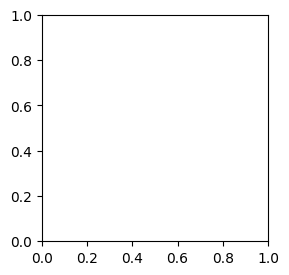

In [15]:
# Visuals
plt.figure(figsize=(10, 10))
i = 0
for image, label in trainData.take(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(str(label.numpy()))
  plt.axis("off")
  i += 1


In [62]:
inputLayer = tf.keras.layers.Input(shape=(360, 360, 3))

baseLayers = tf.keras.layers.Rescaling(1./255)(inputLayer)
baseLayers = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.MaxPooling2D((2, 2))(baseLayers)
baseLayers = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.MaxPooling2D((2, 2))(baseLayers)
baseLayers = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(baseLayers)
baseLayers = tf.keras.layers.Flatten()(baseLayers)
baseLayers = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(baseLayers)
baseLayers = tf.keras.layers.Dropout(0.5)(baseLayers)

#label 
labelLayers = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(baseLayers)
labelOutput = tf.keras.layers.Dense(len(labelTuple), name='labelOutput')(labelLayers)

# cell shape
cellShapeLayers = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(baseLayers)
cellShapeOutput = tf.keras.layers.Dense(len(cellShapeTuple), name='cellShapeOutput')(cellShapeLayers)

# nucleus shape
nucleusShapeLayers = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(baseLayers)
nucleusShapeOutput = tf.keras.layers.Dense(len(nucleusShapeTuple), name='nucleusShapeOutput')(nucleusShapeLayers)

# cytoplasm vacuole
cytoplasmVacuoleLayers = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(baseLayers)
cytoplasmVacuoleOutput = tf.keras.layers.Dense(len(cytoplasmVacuoleTuple), name='cytoplasmVacuoleOutput')(cytoplasmVacuoleLayers)

model = tf.keras.Model(
	inputs=inputLayer, 
	outputs={
    "labelOutput": labelOutput,
    "cellShapeOutput": cellShapeOutput,
    "nucleusShapeOutput": nucleusShapeOutput,
    "cytoplasmVacuoleOutput": cytoplasmVacuoleOutput
	}
)

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss={
    "labelOutput": tf.keras.losses.SparseCategoricalCrossentropy(),
    "cellShapeOutput": tf.keras.losses.SparseCategoricalCrossentropy(),
    "nucleusShapeOutput": tf.keras.losses.SparseCategoricalCrossentropy(),
    "cytoplasmVacuoleOutput": tf.keras.losses.SparseCategoricalCrossentropy()
	},
  metrics={
    "labelOutput": "sparse_categorical_accuracy",
		"cellShapeOutput": "sparse_categorical_accuracy",
		"nucleusShapeOutput": "sparse_categorical_accuracy",
		"cytoplasmVacuoleOutput": "sparse_categorical_accuracy"
  }
)

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 360, 360,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 360, 360,  │      3,584 │ rescaling_6[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 360, 360,  │    147,584 │ conv2d_38[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 360, 360,  │    147,584 │ conv2d_39[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 180, 180,  │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 180, 180,  │     73,792 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 180, 180,  │     36,928 │ conv2d_41[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 180, 180,  │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 90, 90,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 90, 90,    │     18,464 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 90, 90,    │      9,248 │ conv2d_44[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 259200)    │          0 │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │ 16,588,864 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0] 

 Total params: 17,071,791 (65.12 MB)

 Trainable params: 17,071,791 (65.12 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# clean 

for layer in model.layers:
	if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'kernel'):
		layer.kernel.assign(layer.kernel_initializer(layer.kernel.shape, dtype=layer.kernel.dtype))
	if hasattr(layer, 'bias_initializer') and hasattr(layer, 'bias'):
		layer.bias.assign(layer.bias_initializer(layer.bias.shape, dtype=layer.bias.dtype))

tf.keras.backend.clear_session(free_memory=True)


In [63]:
history = model.fit(
  trainData,
  validation_data=valData,
  epochs=4,
	batch_size=10,
	# class_weight=classWeights
)


Epoch 1/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 69s 156ms/step - cellShapeOutput_loss: 3.2542 - cellShapeOutput_sparse_categorical_accuracy: 0.7797 - cytoplasmVacuoleOutput_loss: 1.0928 - cytoplasmVacuoleOutput_sparse_categorical_accuracy: 0.9280 - labelOutput_loss: 8.6224 - labelOutput_sparse_categorical_accuracy: 0.2090 - loss: 23.0934 - nucleusShapeOutput_loss: 8.0576 - nucleusShapeOutput_sparse_categorical_accuracy: 0.2257 - val_cellShapeOutput_loss: 3.4815 - val_cellShapeOutput_sparse_categorical_accuracy: 0.7840 - val_cytoplasmVacuoleOutput_loss: 1.3056 - val_cytoplasmVacuoleOutput_sparse_categorical_accuracy: 0.9190 - val_labelOutput_loss: 9.8643 - val_labelOutput_sparse_categorical_accuracy: 0.1160 - val_loss: 23.6215 - val_nucleusShapeOutput_loss: 6.6271 - val_nucleusShapeOutput_sparse_categorical_accuracy: 0.2440
Epoch 2/4
400/400 ━━━━━━━━━━━━━━━━━━━━ 62s 154ms/step - cellShapeOutput_loss: 3.5089 - cellShapeOutput_sparse_categorical_accuracy: 0.7800 - cytoplasmVacuoleOutput_loss: 1.04

label 0.11599999666213989
cellShape 0.7839999794960022
nucleusShape 0.24400000274181366
cytoplasmVacuole 0.9190000295639038


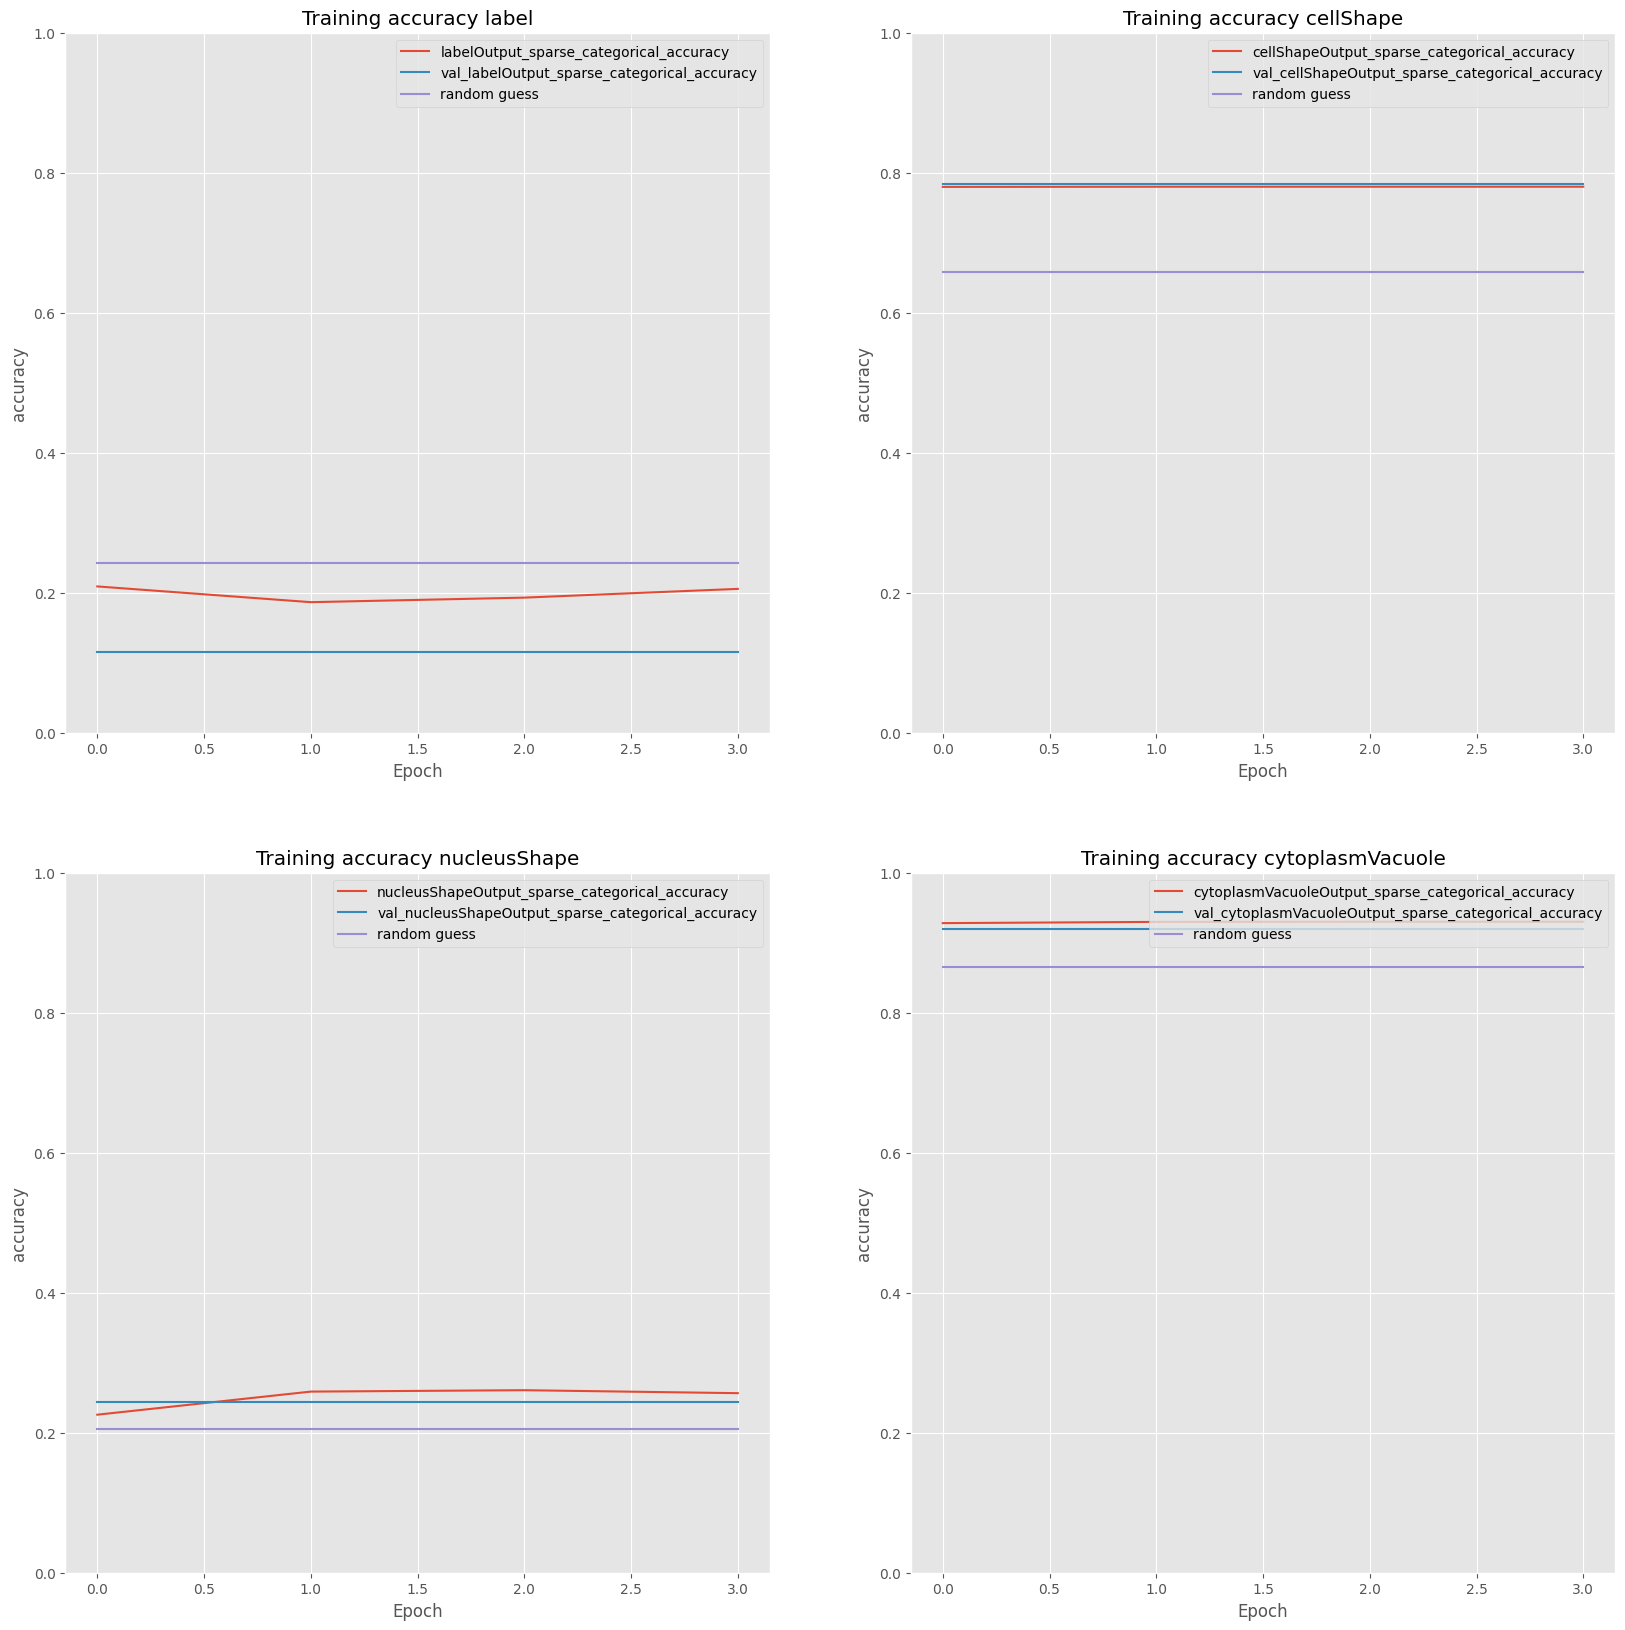

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - cellShapeOutput_loss: 3.4815 - cellShapeOutput_sparse_categorical_accuracy: 0.7840 - cytoplasmVacuoleOutput_loss: 1.3056 - cytoplasmVacuoleOutput_sparse_categorical_accuracy: 0.9190 - labelOutput_loss: 9.8643 - labelOutput_sparse_categorical_accuracy: 0.1160 - loss: 22.9497 - nucleusShapeOutput_loss: 6.6271 - nucleusShapeOutput_sparse_categorical_accuracy: 0.2440


{'cellShapeOutput_loss': 3.481510877609253,
 'cellShapeOutput_sparse_categorical_accuracy': 0.7839999794960022,
 'cytoplasmVacuoleOutput_loss': 1.305565357208252,
 'cytoplasmVacuoleOutput_sparse_categorical_accuracy': 0.9190000295639038,
 'labelOutput_loss': 9.864347457885742,
 'labelOutput_sparse_categorical_accuracy': 0.11599999666213989,
 'loss': 22.949687957763672,
 'nucleusShapeOutput_loss': 6.6271162033081055,
 'nucleusShapeOutput_sparse_categorical_accuracy': 0.24400000274181366}

In [64]:
plt.style.use("ggplot")
plt.figure(figsize=(20,20))
Nepoch=len(history.epoch)

i = 0
for outLabel in ['label', 'cellShape', 'nucleusShape', 'cytoplasmVacuole']:
	i += 1
	plt.subplot(2,2,i)
	trainKey = f'{outLabel}Output_sparse_categorical_accuracy'
	testKey = f'val_{trainKey}'
	
	plt.plot(np.arange(0, Nepoch), history.history[trainKey], label=trainKey)

	plt.plot(np.arange(0, Nepoch), history.history[testKey], label=testKey)
	plt.plot(np.arange(0, Nepoch), [classRandomAcc[outLabel] for i in range(Nepoch)], label='random guess')		

	plt.title(f"Training accuracy {outLabel}")
	plt.ylim(0,1)
	plt.xlabel("Epoch")
	plt.ylabel("accuracy")
	plt.legend(loc="upper right") 

	print(f'{outLabel} {history.history[testKey][-1]}')

plt.show()

model.evaluate(valData, return_dict=True)
